# 4. Building graphs of visually similar images

In the last notebook, we introduced the ability to fetch visually similar images using the `/images` API.

One of the exercises at the end of the notebook asked you to fetch an image's visually similar images, and then fetch the visually similar images of _all of those_ images.

We can think of this process as incrementally building a graph of images, connected each image by their similarity. Nodes are images, and edges exist between the images which are visually similar. In this notebook, we'll develop some code to build and visualize these graphs.

It might also be nice to compare graphs which use different images as their starting points. Do graphs which start at different regions of the image space look different? Do they have different characteristics?

We're going to use a library called networkx to build our graphs. Let's import that, and a few more libraries we'll need.

In [2]:
# for graphs
import networkx as nx

# for making requests to the API and fetching images
import requests

# for processing images
from io import BytesIO
from PIL import Image

## 4.1 Building a graph

Let's start by fetching the visually similar images for a single image, using one of the image IDs from the last notebook.

In [51]:
base_url = "https://api.wellcomecollection.org/catalogue/v2/"
image_id = "z5hm94pv"

In [52]:
response = requests.get(
    base_url + "images/" + image_id,
    params={"include": "visuallySimilar"},
).json()

visually_similar_ids = [
    image['id'] for image in response["visuallySimilar"]
]

We can use networkx to create an empty graph object, and then add nodes and edges to it. We'll start by adding our single source image as a node.

In [53]:
graph = nx.Graph()
graph.add_node(image_id)

We can now add the visually similar images as nodes, and add edges between the source image and each of the visually similar images.

In [54]:
for similar_id in visually_similar_ids:
    graph.add_node(similar_id, color="green")
    graph.add_edge(image_id, similar_id)

`networkx` has a function called `draw()` which we can use to visualize our graph. Let's try that out.

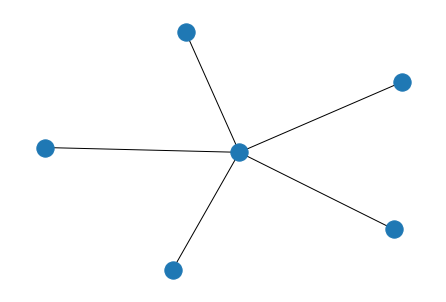

In [55]:
nx.draw(graph)

Now, let's fetch the next set of visually similar images - 5 new possible connections for each of the visually similar images which we just added. We'll add those to the graph, and then visualize it again.

In [56]:
for first_round_similar_id in visually_similar_ids:
    response = requests.get(
        base_url + "images/" + first_round_similar_id,
        params={"include": "visuallySimilar"},
    ).json()

    second_round_similar_ids = [
        image['id'] for image in response["visuallySimilar"]
    ]

    for similar_id in second_round_similar_ids:
        # make these nodes a different colour
        graph.add_node(similar_id)
        graph.add_edge(first_round_similar_id, similar_id)

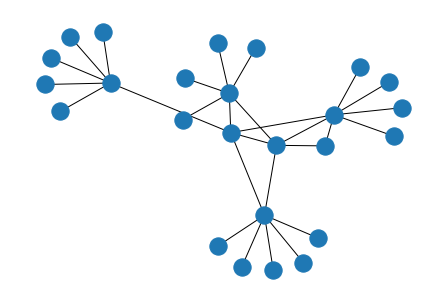

In [57]:
nx.draw(graph)

Great! Notice that some of the connections are shared between sets of visually similar images. Note also that some of the first round images have fewer than 5 further connections. This happens when some of the visually similar images are already in the graph!

Let's wipe the slate clean and keep exploring.

In [58]:
graph.clear()

We can wrap this functionality up in a single function, which will take any image ID and build a graph of visually similar images up to `n` levels deep.

In [59]:
def build_graph(source_id, n):
    graph = nx.Graph()

    graph.add_node(source_id)

    image_ids_to_fetch = [source_id]

    for _ in range(n):
        new_image_ids = []
        for image_id in image_ids_to_fetch:
            res = requests.get(
                base_url + "images/" + image_id,
                params={"include": "visuallySimilar"},
            ).json()

            for similar_image in res["visuallySimilar"]:
                graph.add_node(similar_image["id"])
                graph.add_edge(image_id, similar_image["id"])

                new_image_ids.append(similar_image["id"])

        image_ids_to_fetch = new_image_ids

    return graph

In [60]:
graph = build_graph("xmcz3cgb", 3)

In [61]:
len(graph.nodes)

96

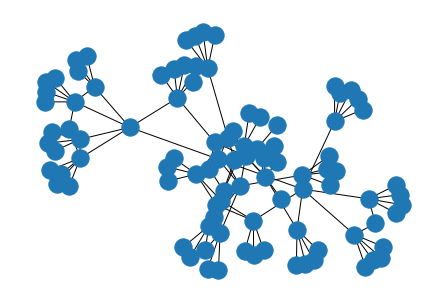

In [62]:
nx.draw(graph)

## 4.2 Characterising graphs

Now that we have a function which can build a graph of visually similar images, let's use it to build a few graphs and see how different graphs behave.

In [66]:
graph_1 = build_graph("esyjaets", 2)

# a different source image
graph_2 = build_graph("xmcz3cgb", 2)

# same id as graph_2, but with a different depth
graph_3 = build_graph("xmcz3cgb", 3)

We can use various metrics to get a sense of what's going on in the graph, without visualising it.

The _density_ of a graph gives an indication of how connected it is. Density values for regular graphs are are given between 0-1, where a graph without any edges has density 0, and a completely connected graph (where every possible edge between nodes exists) has a density of 1.

In [67]:
print(
    nx.density(graph_1),
    nx.density(graph_2),
    nx.density(graph_3),
)

0.13450292397660818 0.08547008547008547 0.02675438596491228


It makes sense that as we add more nodes and edges to the graph, the density will decrease, as each new node only adds one new edge out of many possible edges. That number of possible edges only increases as we take more steps away from the source image.

## 4.3 Better visualizations

It might be more interesting to look at the images themselves in our graph visualisations, rather than just plotting dots and lines. We might then notice patterns in _why_ clusters of visually similar images exist in the graph. 

Let's use some code adapted from [the networkx documentation](https://networkx.org/documentation/stable/auto_examples/drawing/plot_custom_node_icons.html) to do this.

In [68]:
import urllib
import matplotlib.pyplot as plt
import numpy as np

def draw_images_on_nodes_of_graph(graph):
    pos = nx.spring_layout(graph, seed=1734289230)
    fig, ax = plt.subplots(figsize=(20, 20))

    nx.draw_networkx_edges(
        graph,
        pos=pos,
        ax=ax,
    )

    for image_id in graph.nodes:
        image_data = requests.get(base_url + "images/" + image_id).json()
        image_url = image_data["thumbnail"]["url"]
        image_url = image_url.replace("info.json", "full/400,/0/default.jpg")
        image_response = urllib.request.urlopen(image_url)
        image = np.array(Image.open(image_response))
        graph.nodes[image_id]["image"] = image

    tr_figure = ax.transData.transform
    tr_axes = fig.transFigure.inverted().transform

    image_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01
    image_center = image_size / 2.0

    for n in graph.nodes:
        xf, yf = tr_figure(pos[n])
        xa, ya = tr_axes((xf, yf))
        a = plt.axes(
            [xa - image_center, ya - image_center, image_size, image_size]
        )
        a.imshow(graph.nodes[n]["image"], alpha=0.6)
        a.axis("off")

    plt.show();

In [74]:
graph_4 = build_graph("rdc2bj3e", 3)

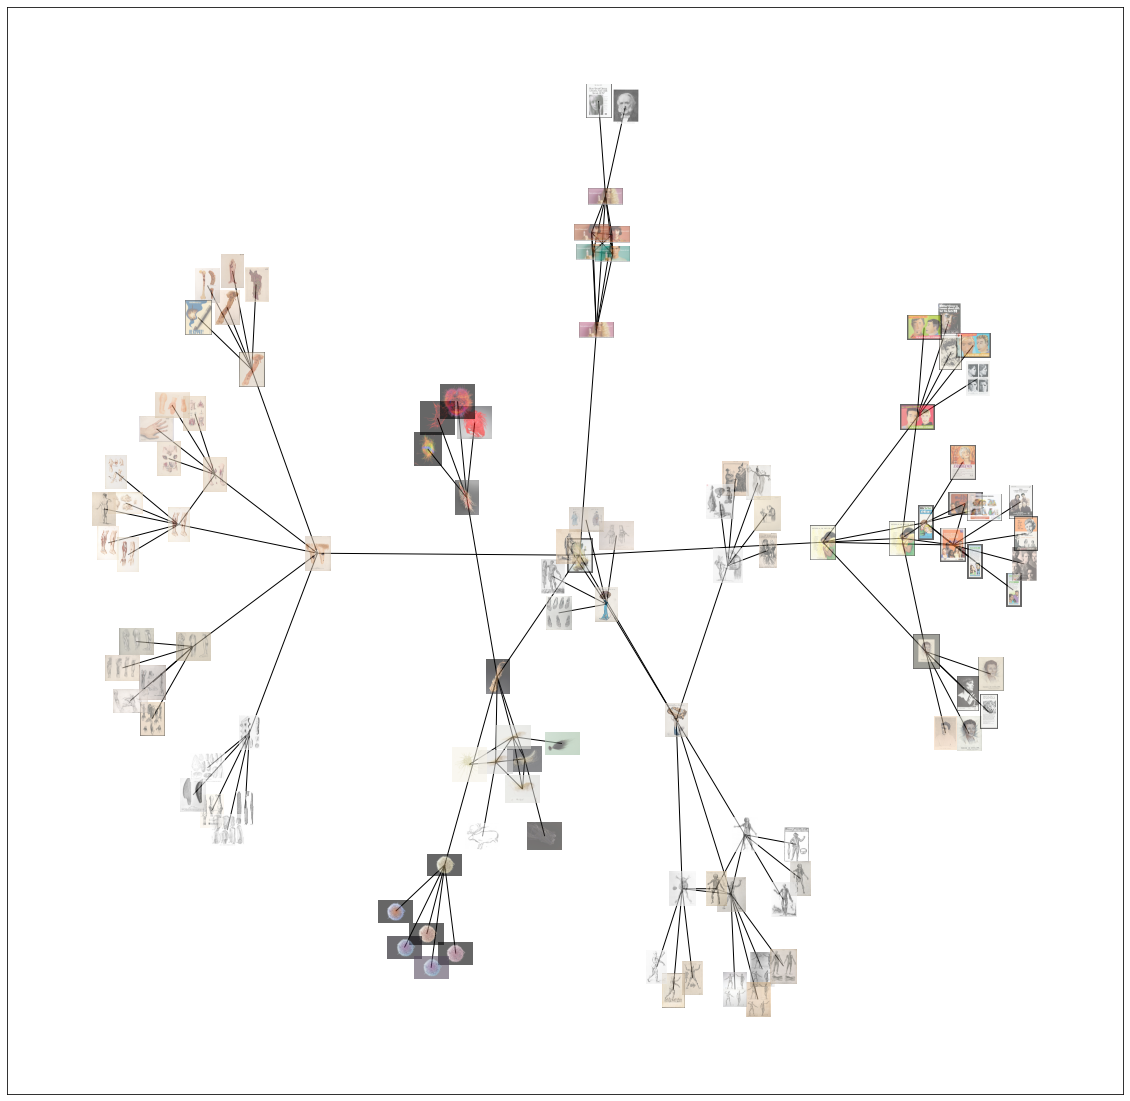

In [75]:
draw_images_on_nodes_of_graph(graph_4)

## Exercises

1. Try building graphs from different source images. Do they look different? Do they have different characteristics?
2. Try building graphs with different numbers of levels. How does this affect the density of the graph?
3. Try using some different metrics to characterise the graphs - I'd suggest looking at the `degree_histogram()` to start with ([see the networkx documentation here](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.degree_histogram.html#networkx.classes.function.degree_histogram)). What do the different metrics tell you about different graphs graphs? 